In [7]:
import os
import sys
import yaml
from HydraSalsa import HydraSalsa
from HydraKitti import HydraKitti
sys.path.append('/ari/users/ibaskaya/projeler/hydrasalsa/utils')

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob


from lovasz import Lovasz_softmax
from parser1 import Parser
from mappings import kitti, sq_w2k , sq_w2k_mid, kitti_normalized_frequencies ,kitticolormap,sem2sem, kitti_lm_inv,waymocolormap,waymo,sensor_kitti,sensor_waymo,waymo_lmap, waymo_lmap_inv,waymovalidfreqs,sq_w2k_safe
from iou_eval import iouEval
from combinedloader import KittiWaymoTrainLoader
import importlib
import dskittiwaymo  # Import the module
importlib.reload(dskittiwaymo)
from dskittiwaymo import SegmentationDataset


In [12]:
num_classes = 23
batch_number = 24
batch_size,workers = 24, 24              
epsilon_w = 0.001 

freqsum = sum(waymovalidfreqs)
frequencies = [i/freqsum for i in waymovalidfreqs]

root_waymo = '/ari/users/ibaskaya/projeler/hydrasalsa/data/waymo'
root_kitti = '/ari/users/ibaskaya/projeler/hydrasalsa/data/kitti'

train_sequences = [0,1,2,3,4,5,6,7,9,10]
valid_sequences = [8]
test_sequences = None
labels_waymo = waymo
color_map_waymo = waymocolormap
learning_map_waymo = waymo_lmap
learning_map_inv_waymo = waymo_lmap_inv

labels_kitti = kitti
color_map_kitti = kitticolormap
learning_map_kitti = sem2sem
learning_map_inv_kitti = kitti_lm_inv


max_points_waymo=170000
max_points_kitti = 150000
gt=True
transform=False
iswaymo = False
istrain = False

salsanextkitti = '/ari/users/ibaskaya/projeler/kittisalsa/kitti_best_model_state_dict.pth'
from SalsaNext import SalsaNext
model = SalsaNext()
model.load_state_dict(torch.load(salsanextkitti))

hydra = HydraSalsa(nclasses=[20,23], inchannels=5)
hydra.load_state_dict(torch.load('/ari/users/ibaskaya/projeler/hydrasalsa/kagglemodels/best_kitti_state_dict.pth'))
model = HydraKitti(hydra)

parser_waymo = Parser(root_waymo,              # directory for data
            train_sequences,   # sequences to train
            valid_sequences,   # sequences to validate.
            test_sequences,    # sequences to test (if none, don't get)
            labels_waymo,            # labels in data
            color_map_waymo,         # color for each label
            learning_map_waymo,      # mapping for training labels
            learning_map_inv_waymo,  # recover labels from xentropy
            sensor_waymo,            # sensor to use
            max_points_waymo,        # max points in each scan in entire dataset
            batch_size,        # batch size for train and val
            workers,           # threads to load data
            gt=True,           # get gt?
            shuffle_train=True,
            iswaymo = True)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.device_count()>1:
    model = torch.nn.DataParallel(model)
    model.to(device)
else:
    model.to(device)

print(device, ' is used')


#wvalidation_dataloader = parser_waymo.validloader

sds = SegmentationDataset(root = '/ari/users/ibaskaya/projeler/hydrasalsa/data/waymo', split = 'validation', 
transform=None, pretransform=None, fastfill=None, iswaymo=True, width=2048)

wvalidation_dataloader = torch.utils.data.DataLoader(sds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=10)

num_classes_waymo = 23
num_classes_kitti = 20
best_mean_iou_waymo = 0.0
metric_waymo = iouEval(num_classes_waymo,device,0)
best_mean_iou_kitti = 0.0
metric_kitti = iouEval(num_classes_kitti,device,0)

# Validation phase
model.eval()
miou_total_kitti = 0.0
miou_total_waymo = 0.0
batch_results_kitti, batch_results_waymo = [], [] 


/tmp/ipykernel_56914/965601112.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(salsanextkitti))
/tmp/ipykernel_56914/965601112.py:39: F

Sequences folder exists! Using sequences from /ari/users/ibaskaya/projeler/hydrasalsa/data/waymo/training
Using 23691 scans from sequences [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
Sequences folder exists! Using sequences from /ari/users/ibaskaya/projeler/hydrasalsa/data/waymo/validation
Using 5976 scans from sequences [8]
cuda  is used
[IOU EVAL] IGNORE:  tensor(0)
[IOU EVAL] INCLUDE:  tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22])
[IOU EVAL] IGNORE:  tensor(0)
[IOU EVAL] INCLUDE:  tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19])


In [9]:
metric_kitti.reset()
label_map_dict = sq_w2k_mid
max_label = max(label_map_dict.keys())
lookup_tensor = torch.full((max_label + 1,), -1, dtype=torch.long, device=device)
for key, value in label_map_dict.items():
    lookup_tensor[key] = value

with torch.no_grad():
    for i, (images, masks) in tqdm(enumerate(wvalidation_dataloader)):
        images, masks = images.to(torch.float32).to(device), masks.to(torch.long).to(device)
        outputs = model(images)
        labels = lookup_tensor[masks]
        preds = torch.argmax(outputs, dim=1)
        metric_kitti.addBatch(preds,labels)

mean_iou_waymo = metric_kitti.getIoU()[0].item()
accval_waymo = metric_kitti.getacc().item()

# Calculate and display mIoU metrics
print('###################WAYMO_RESULTS########################')
print(f"Waymo Validation mIoU: {mean_iou_waymo:.4f}")
print(f"Waymo Validation Acc.: {accval_waymo:.4f}")
print(metric_kitti.getIoU())
print('########################################################')

0it [00:00, ?it/s]

249it [01:15,  3.29it/s]


###################WAYMO_RESULTS########################
Waymo Validation mIoU: 0.0786
Waymo Validation Acc.: 0.2923
(tensor(0.0786, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.2608, 0.0198, 0.0019, 0.0539, 0.0131, 0.0672, 0.0831, 0.0000,
        0.0215, 0.0000, 0.0663, 0.0602, 0.3314, 0.0000, 0.1294, 0.0623, 0.0000,
        0.1780, 0.1448], device='cuda:0', dtype=torch.float64))
########################################################


In [ ]:
"""
Not remembering
(tensor(0.4763, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.9677, 0.2392, 0.0000, 0.0000, 0.1302, 0.5380, 0.8886, 0.0000,
        0.9606, 0.0550, 0.8671, 0.0000, 0.8817, 0.3250, 0.6893, 0.7438, 0.7732,
        0.4946, 0.4949], device='cuda:0', dtype=torch.float64))
#########################
Hydra on Kitti
        ###################KITTI_RESULTS########################
Kitti Validation mIoU: 0.6079
Kitti Validation Acc.: 0.9071
(tensor(0.6079, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.9484, 0.4270, 0.5591, 0.7367, 0.4537, 0.6926, 0.8104, 0.0016,
        0.9413, 0.4491, 0.8117, 0.0235, 0.8572, 0.5139, 0.8539, 0.6476, 0.7409,
        0.5844, 0.4974], device='cuda:0', dtype=torch.float64))
########################################################
        
Salsa on Kitti
###################KITTI_RESULTS########################
Kitti Validation mIoU: 0.6097
Kitti Validation Acc.: 0.9048
(tensor(0.6097, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.9426, 0.3947, 0.5126, 0.7527, 0.4703, 0.7135, 0.7964, 0.0000,
        0.9420, 0.4501, 0.8132, 0.0884, 0.8692, 0.5479, 0.8429, 0.6570, 0.7143,
        0.5796, 0.4973], device='cuda:0', dtype=torch.float64))
########################################################
"""

"""249it [02:40,  1.55it/s] With domain change on Hydra safe
###################WAYMO_RESULTS########################
Waymo Validation mIoU: 0.1495
Waymo Validation Acc.: 0.4754
(tensor(0.1495, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.6693, 0.0349, 0.0281, 0.0934, 0.0501, 0.3090, 0.0120, 0.0000,
        0.1666, 0.0000, 0.3775, 0.0000, 0.4331, 0.0000, 0.2864, 0.3796, 0.0000,
        0.0000, 0.0000], device='cuda:0', dtype=torch.float64))
########################################################"""

"""0it [00:00, ?it/s] With Domain Change on Hydra free
249it [02:02,  2.03it/s]
###################WAYMO_RESULTS########################
Waymo Validation mIoU: 0.1533
Waymo Validation Acc.: 0.3163
(tensor(0.1533, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.4823, 0.0262, 0.0067, 0.0288, 0.0316, 0.2094, 0.0115, 0.0000,
        0.1074, 0.0000, 0.1929, 0.1828, 0.3644, 0.0000, 0.2412, 0.3498, 0.0000,
        0.3942, 0.2836], device='cuda:0', dtype=torch.float64))
########################################################"""

""" With domain change on Hydra mid
249it [02:16,  1.83it/s]
###################WAYMO_RESULTS########################
Waymo Validation mIoU: 0.1840
Waymo Validation Acc.: 0.4387
(tensor(0.1840, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.6642, 0.0331, 0.0274, 0.0844, 0.0485, 0.2963, 0.0118, 0.0000,
        0.1038, 0.0000, 0.2707, 0.2063, 0.4261, 0.0000, 0.2813, 0.3552, 0.0000,
        0.4007, 0.2856], device='cuda:0', dtype=torch.float64))
########################################################
"""
""" With domain change on Salsa
249it [02:31,  1.64it/s]
###################WAYMO_RESULTS########################
Waymo Validation mIoU: 0.1198
Waymo Validation Acc.: 0.3778
(tensor(0.1198, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.5377, 0.0021, 0.0006, 0.0276, 0.0387, 0.1124, 0.0157, 0.0000,
        0.0595, 0.0000, 0.1439, 0.0366, 0.5253, 0.0000, 0.1222, 0.1837, 0.0000,
        0.2857, 0.1856], device='cuda:0', dtype=torch.float64))
########################################################
"""

"""Without domain change on Salsa
###################WAYMO_RESULTS########################
Waymo Validation mIoU: 0.0786
Waymo Validation Acc.: 0.2923
(tensor(0.0786, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.2608, 0.0198, 0.0019, 0.0539, 0.0131, 0.0672, 0.0831, 0.0000,
        0.0215, 0.0000, 0.0663, 0.0602, 0.3314, 0.0000, 0.1294, 0.0623, 0.0000,
        0.1780, 0.1448], device='cuda:0', dtype=torch.float64))
########################################################
"""

In [ ]:
kitti_lm_inv = {
  0: 0,      # "unlabeled", and others ignored
  1: 10 ,    # "car"
  2: 11  ,   # "bicycle"
  3: 15   ,  # "motorcycle"
  4: 18    , # "truck"
  5: 20     ,# "other-vehicle"
  6: 30     ,# "person"
  7: 31 ,    # "bicyclist"
  8: 32  ,   # "motorcyclist"
  9: 40   ,  # "road"
  10: 44   , # "parking"
  11: 48   , # "sidewalk"
  12: 49 ,   # "other-ground"
  13: 50  ,  # "building"
  14: 51   , # "fence"
  15: 70    ,# "vegetation"
  16: 71   , # "trunk"
  17: 72    ,# "terrain"
  18: 80    ,# "pole"
  19: 81    # "traffic-sign"
}

In [10]:
print(metric_waymo.getIoU())

(tensor(0.1230, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.5917, 0.0000, 0.1168, 0.1398, 0.0780, 0.2126, 0.0259, 0.0000,
        0.1345, 0.0000, 0.3587, 0.0000, 0.4628, 0.0000, 0.3065, 0.2795, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0',
       dtype=torch.float64))


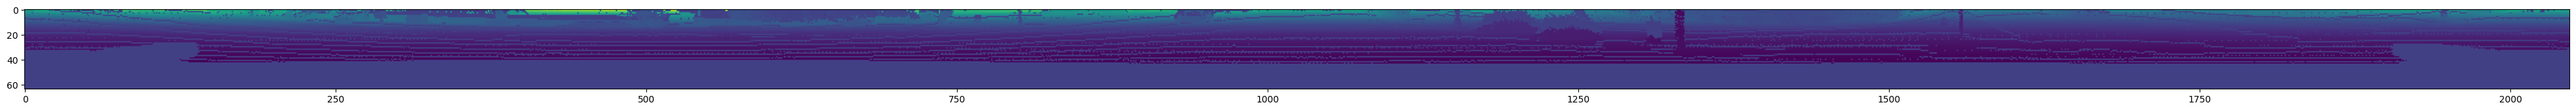

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 10))
plt.imshow(images[10][0].cpu().numpy())
plt.show()


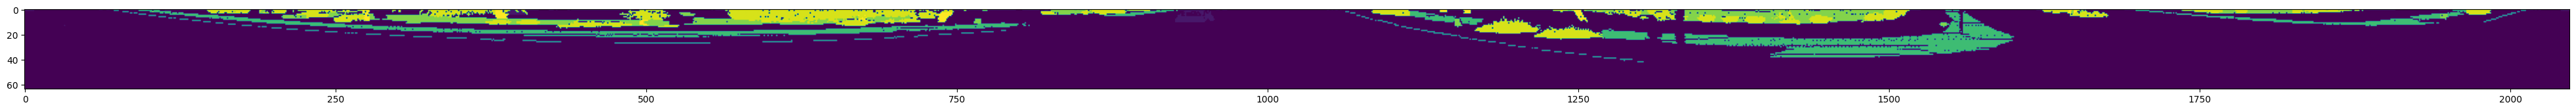

In [24]:
plt.figure(figsize=(50, 10))
plt.imshow(labels[10].cpu().numpy())
plt.show()

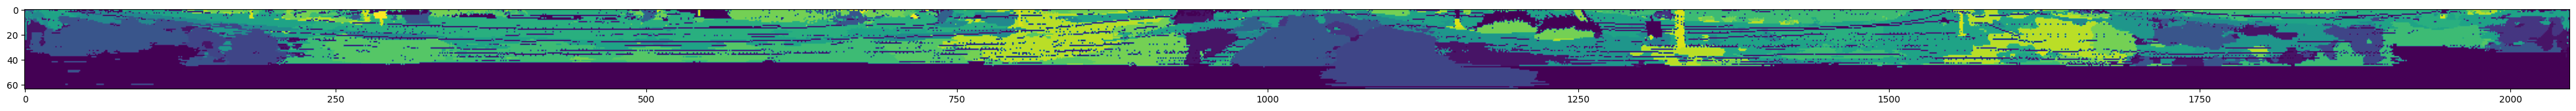

In [25]:
plt.figure(figsize=(50, 10))
plt.imshow(preds[10].cpu().numpy())
plt.show()

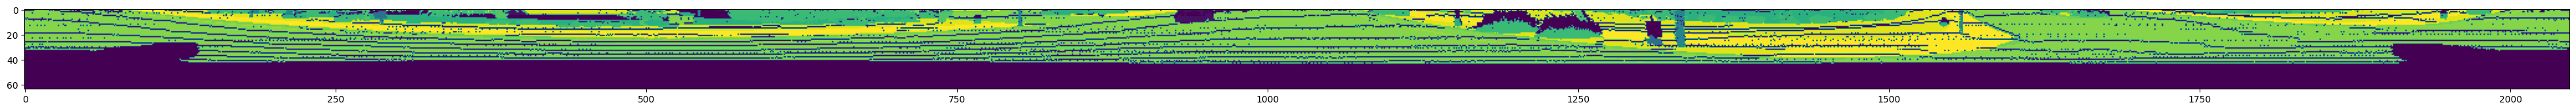

In [26]:
plt.figure(figsize=(50, 10))
plt.imshow(masks[10].cpu().numpy())
plt.show()

In [13]:
from dskittiwaymo import SegmentationDataset
sds = SegmentationDataset(root = '/ari/users/ibaskaya/projeler/hydrasalsa/data/kitti', split = 'validation', 
transform=None, pretransform=None, fastfill=None, iswaymo=False, width=2048)

kvalidation_dataloader = torch.utils.data.DataLoader(sds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=10)

metric_kitti.reset()
with torch.no_grad():
    for i, (images, masks) in tqdm(enumerate(kvalidation_dataloader)):
        images, masks = images.to(torch.float32).to(device), masks.to(torch.long).to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        metric_kitti.addBatch(preds,masks)


mean_iou_kitti = metric_kitti.getIoU()[0].item()
accval_kitti = metric_kitti.getacc().item()

# Calculate and display mIoU metrics
print('###################KITTI_RESULTS########################')
print(f"Kitti Validation mIoU: {mean_iou_kitti:.4f}")
print(f"Kitti Validation Acc.: {accval_kitti:.4f}")
print(metric_kitti.getIoU())
print('########################################################')


0it [00:00, ?it/s]

170it [00:59,  2.85it/s]

###################KITTI_RESULTS########################
Kitti Validation mIoU: 0.6079
Kitti Validation Acc.: 0.9071
(tensor(0.6079, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.9484, 0.4270, 0.5591, 0.7367, 0.4537, 0.6926, 0.8104, 0.0016,
        0.9413, 0.4491, 0.8117, 0.0235, 0.8572, 0.5139, 0.8539, 0.6476, 0.7409,
        0.5844, 0.4974], device='cuda:0', dtype=torch.float64))
########################################################


In [14]:
print(metric_kitti.getIoU())

(tensor(0.6079, device='cuda:0', dtype=torch.float64), tensor([0.0000, 0.9484, 0.4270, 0.5591, 0.7367, 0.4537, 0.6926, 0.8104, 0.0016,
        0.9413, 0.4491, 0.8117, 0.0235, 0.8572, 0.5139, 0.8539, 0.6476, 0.7409,
        0.5844, 0.4974], device='cuda:0', dtype=torch.float64))


In [15]:
model

HydraKitti(
  (encoder): SalsaEncoder(
    (downCntx): ResContextBlock(
      (conv1): Conv2d(5, 32, kernel_size=(1, 1), stride=(1, 1))
      (act1): ReLU6()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU6()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (act3): ReLU6()
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (downCntx2): ResContextBlock(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (act1): ReLU6()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU6()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (act3)